### Chat Model

In [1]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

### Embedding Model

In [2]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="nomic-embed-text:v1.5")

### Vector Store

In [3]:
# Local Storage

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

# Indexing

### Loading document

In [4]:
from langchain_community.document_loaders import PyPDFLoader

file_path = './Hostel_Affidavit_Men_2024-Chennai_Updated.pdf'
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [5]:
for part in pages[0]:
    print(part)

('id', None)
('metadata', {'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2024-06-13T07:51:16+05:30', 'author': 'Windows User', 'moddate': '2024-06-13T07:51:16+05:30', 'source': './Hostel_Affidavit_Men_2024-Chennai_Updated.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'})
('page_content', "JOINT AFFIDAVIT BY PARENT / GUARDIAN AND STUDENT \n(This matter has to be typed on a non-judicial stamp paper of ₹200/-) \n \nMr./Mrs./Ms ...............................................................................................(Full name of parent / guardian) father / mother/ guardian \nof …......................................................... (Full name of student with admission / registration / enrolment number), have been \nadmitted to .............................................................................(Name of the Program and Institution). I/we have read and understood \nthe hereunder specified Rules and Regulations of VIT Men's Hos

In [6]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2024-06-13T07:51:16+05:30', 'author': 'Windows User', 'moddate': '2024-06-13T07:51:16+05:30', 'source': './Hostel_Affidavit_Men_2024-Chennai_Updated.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}

JOINT AFFIDAVIT BY PARENT / GUARDIAN AND STUDENT 
(This matter has to be typed on a non-judicial stamp paper of ₹200/-) 
 
Mr./Mrs./Ms ...............................................................................................(Full name of parent / guardian) father / mother/ guardian 
of …......................................................... (Full name of student with admission / registration / enrolment number), have been 
admitted to .............................................................................(Name of the Program and Institution). I/we have read and understood 
the hereunder specified Rules and Regulations of VIT Men's Hostel. I/we agree to obey by the Hostel Rules and Re

In [7]:
print(f"Total characters: {len(pages[0].page_content)}")

Total characters: 4822


### Splitting document

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)

all_splits = text_splitter.split_documents(pages)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 6 sub-documents.


### Storing documents

In [9]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['eedf39e6-c3d6-4a76-9b4b-74e6287cba1e', '7ebbbc2b-c8d9-4809-a4a3-e74cc10d7aca', 'cf1eb3be-d656-4073-8da8-0c202d906913']


In [10]:
document_ids

['eedf39e6-c3d6-4a76-9b4b-74e6287cba1e',
 '7ebbbc2b-c8d9-4809-a4a3-e74cc10d7aca',
 'cf1eb3be-d656-4073-8da8-0c202d906913',
 '3803911c-efb9-4475-8434-a9bea7ddaf41',
 '9b110679-fc97-42f2-b08c-a7418c30189f',
 '293705f1-8fde-458a-900d-9db672918539']

# Retrieval

### Defining State (TypeDict or Pydantic BaseModel)

In [11]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Custom Prompt

In [18]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

# Retrieve and Generate

In [19]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# Control Flow

In [20]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

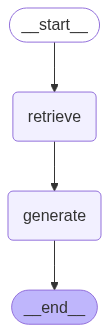

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Invoking prompt

In [22]:
result = graph.invoke({"question": "What are the rules in the affidavit?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='eedf39e6-c3d6-4a76-9b4b-74e6287cba1e', metadata={'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2024-06-13T07:51:16+05:30', 'author': 'Windows User', 'moddate': '2024-06-13T07:51:16+05:30', 'source': './Hostel_Affidavit_Men_2024-Chennai_Updated.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1', 'start_index': 0}, page_content="JOINT AFFIDAVIT BY PARENT / GUARDIAN AND STUDENT \n(This matter has to be typed on a non-judicial stamp paper of ₹200/-) \n \nMr./Mrs./Ms ...............................................................................................(Full name of parent / guardian) father / mother/ guardian \nof …......................................................... (Full name of student with admission / registration / enrolment number), have been \nadmitted to .............................................................................(Name of the Program and Institution). I/we have read and understood \nthe